## Imports & Setup
This notebook is tested on SageMaker Notebook instance type: ml.t3.medium, Elastic Inference: none, Platform identifier: Amazon Linux 2, Jupyter Lab 3 and conda_python3 kernel.

In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [3]:
import os
import time
import boto3
import fileinput
import numpy as np
import pandas as pd
import awswrangler as wr
import seaborn as sns
import matplotlib.pyplot as plt

from dataclasses import dataclass
from s3pathlib import S3Path

from sklearn.model_selection import train_test_split

import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    CategoricalParameter,

    TuningJobCompletionCriteriaConfig,
    HyperparameterTuner,
    )

# Configure settings
pd.set_option("display.max_rows", 50)

In [4]:
session = sagemaker.session.Session()
region = session.boto_region_name

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
sm_role = sagemaker.get_execution_role()

BUCKET = session.default_bucket()
PREFIX = "01-automl"

s3_data = S3Path(BUCKET, PREFIX)

## Upload Data

In [5]:
s3_client.download_file(
    f"sagemaker-example-files-prod-{region}",
    f"datasets/tabular/california_housing/cal_housing.tgz",
    "cal_housing.tgz",
)
!tar -zxf cal_housing.tgz
columns = [
    "longitude",
    "latitude",
    "housingMedianAge",
    "totalRooms",
    "totalBedrooms",
    "population",
    "households",
    "medianIncome",
    "medianHouseValue",
]
df_california = pd.read_csv("CaliforniaHousing/cal_housing.data", names=columns, header=None)

In [6]:
df_california.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [7]:
df_train, df_test = train_test_split(df_california, test_size=0.2, random_state=42)

if not os.path.exists("data"):
    os.makedirs("data")
df_train.to_parquet("data/df_train.parquet", index=False)
df_test.to_parquet("data/df_test.parquet", index=False)

s3_data_train = s3_data.joinpath("train.parquet")
s3_data_test = s3_data.joinpath("test.parquet")

wr.s3.upload(local_file="data/df_train.parquet", path=s3_data_train.uri)
wr.s3.upload(local_file="data/df_test.parquet", path=s3_data_test.uri)

## Create Training Scripts

In [8]:
# Create base script 
_script = """
import argparse
import joblib
import os

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

###########################
### Inference functions ###
###########################

def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

if __name__ == "__main__":

    print("Extracting arguments")
    parser = argparse.ArgumentParser()

    # Hyperparameters
    ##### WILL BE INSERTED DYNAMICALLY #####
    {}

    ############################

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train.parquet")
    parser.add_argument("--test-file", type=str, default="test.parquet")
    parser.add_argument("--features", type=str)
    parser.add_argument("--target", type=str)

    args, _ = parser.parse_known_args()

    # Load and prepare data
    train_df = pd.read_parquet(os.path.join(args.train, args.train_file))
    test_df = pd.read_parquet(os.path.join(args.test, args.test_file))

    X_train = train_df[args.features.split()]
    X_test = test_df[args.features.split()]
    y_train = train_df[args.target]
    y_test = test_df[args.target]

    # Train model
    ##### WILL BE INSERTED DYNAMICALLY #####
    {}
    {}
    
    
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)

    # Validate model and print metrics
    rmse = mean_squared_error(y_test, pipeline.predict(X_test), squared=False)
    print("RMSE: " + str(rmse))

    # Persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(pipeline, path)
"""

# write _script to file just to have it in hand
with open("script_draft.py", "w") as f:
    print(_script, file=f)

In [9]:
# We are reusing a generic training script into which we will dynamically insert each algorithm hyperparameter arguments and the model call itself

preprocessors = {
    "mean-imp-scale": "preprocessor = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])\n",
    "mean-imp-scale-knn": "preprocessor = FeatureUnion([('base-features', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])), ('knn', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler()), ('knn', KMeans(n_clusters=10))]))])\n",
    "mean-imp-scale-pca": "preprocessor = FeatureUnion([('base-features', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])), ('pca', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler()), ('pca', PCA(n_components=0.9))]))])\n"   
}

models = {
    "rf": {
        "script_output": None,
        "insertions": {
            # Arguments
            "arguments" : 
            "parser.add_argument('--n_estimators', type=int, default=100)\n"+
            "    parser.add_argument('--max_depth', type=int, default=None)\n"+            
            "    parser.add_argument('--min_samples_leaf', type=int, default=1)\n"+
            "    parser.add_argument('--min_samples_split', type=int, default=2)\n"+            
            "    parser.add_argument('--max_features', type=str, default='auto')\n",
            # Model call
            "preprocessor": None,
            "model_call" : "model = RandomForestRegressor(n_estimators=args.n_estimators,max_depth=args.max_depth,min_samples_leaf=args.min_samples_leaf,min_samples_split=args.min_samples_split,max_features=args.max_features)\n"
        },
        "hyperparameters": {
            "n_estimators": IntegerParameter(100, 2000, "Linear"),
            "max_depth": IntegerParameter(1, 100, "Logarithmic"),
            "min_samples_leaf": IntegerParameter(1, 6, "Linear"),
            "min_samples_split": IntegerParameter(2, 20, "Linear"),
            "max_features": CategoricalParameter(["auto", "sqrt", "log2"]),
        },
        "include_cls_metadata": False,
    },
    "gb": {
        "script_output": None,
        "insertions": {
            # Arguments
            "arguments" : 
            "parser.add_argument('--n_estimators', type=int, default=100)\n"+
            "    parser.add_argument('--learning_rate', type=float, default=0.1)\n"+
            "    parser.add_argument('--subsample', type=float, default=1.0)\n"+
            "    parser.add_argument('--min_samples_split', type=int, default=2)\n"+
            "    parser.add_argument('--max_features', type=str, default='auto')\n"+
            "    parser.add_argument('--max_depth', type=int, default=3)\n",
            # Model call
            "preprocessor": None,
            "model_call" : "model = GradientBoostingRegressor(n_estimators=args.n_estimators,learning_rate=args.learning_rate,subsample=args.subsample,min_samples_split=args.min_samples_split,max_features=args.max_features,max_depth=args.max_depth)\n"
        },
        "hyperparameters": {
            "n_estimators": IntegerParameter(100, 2000, "Linear"),
            "learning_rate": ContinuousParameter(0.01, 0.5, "Logarithmic"),
            "subsample": ContinuousParameter(0.6, 1, "Linear"),
            "min_samples_split": IntegerParameter(2, 20, "Linear"),            
            "max_features": CategoricalParameter(["auto", "sqrt", "log2"]),
            "max_depth": IntegerParameter(1, 100, "Logarithmic"),
        },
        "include_cls_metadata": False,
    },
    "en": {
        "script_output": None,
        "insertions": {
            # Arguments
            "arguments" : 
            "parser.add_argument('--alpha', type=float, default=0.1)\n"+
            "    parser.add_argument('--l1_ratio', type=float, default=0.5)\n",
            # Model call
            "preprocessor": None,
            "model_call" : "model = ElasticNet(alpha=args.alpha,l1_ratio=args.l1_ratio)\n"
        },
        "hyperparameters": {
            "alpha": ContinuousParameter(0.0001, 1, "Logarithmic"),
            "l1_ratio": ContinuousParameter(0, 1),
        },
        "include_cls_metadata": False,
    },
 
}

pipelines = {}
for model_name, model_spec in models.items():
    pipelines[model_name] = {}
    for preprocessor_name, preprocessor_spec in preprocessors.items():
        pipeline_name = f"{model_name}-{preprocessor_name}"
        pipelines[model_name][pipeline_name] = {}
        pipelines[model_name][pipeline_name]["insertions"] = {}
        pipelines[model_name][pipeline_name]["insertions"]["preprocessor"] = preprocessor_spec
        pipelines[model_name][pipeline_name]["hyperparameters"] = model_spec["hyperparameters"]
        pipelines[model_name][pipeline_name]["include_cls_metadata"] = model_spec["include_cls_metadata"]        
        pipelines[model_name][pipeline_name]["insertions"]["arguments"] = model_spec["insertions"]["arguments"]
        pipelines[model_name][pipeline_name]["insertions"]["model_call"] = model_spec["insertions"]["model_call"]
        pipelines[model_name][pipeline_name]["script_output"] = f"scripts/{model_name}/script-{pipeline_name}.py"

In [10]:
# Create individual pipeline script files dynamically by using dictionary created previously

for pipeline_family in pipelines.keys():
    if not os.path.exists(f"scripts/{pipeline_family}"):
        os.makedirs(f"scripts/{pipeline_family}")
        
for pipeline_family, pipelines_dict in pipelines.items():
    for pipeline, pipeline_spec in pipelines_dict.items():
        with open(pipeline_spec["script_output"], "w") as new_file:
            print(_script.format(pipeline_spec["insertions"]["arguments"], pipeline_spec["insertions"]["preprocessor"], pipeline_spec["insertions"]["model_call"]), file=new_file)

In [11]:
# Create a base version of the class with default parameters for all estimators

class SKLearnBase(SKLearn):
    def __init__(
        self, 
        entry_point=".", # intentionally left blank, will be overwritten in the next function
        framework_version="1.2-1",
        role=sm_role,
        instance_count=1,
        instance_type="ml.m5.large", # deliberately kept the instance small to reduce costs
        hyperparameters={
            "features": "medianIncome housingMedianAge totalRooms totalBedrooms population households latitude longitude",
            "target": "medianHouseValue",
        },  
        **kwargs,
        ):
        super(SKLearnBase, self).__init__(
            entry_point=entry_point,
            framework_version=framework_version,
            role=role,
            instance_count=instance_count,
            instance_type=instance_type,
            hyperparameters=hyperparameters,
            **kwargs
        )

In [12]:
estimators = {}
for pipeline_family in pipelines.keys():
    estimators[pipeline_family] = {}
    scripts = os.listdir(f"scripts/{pipeline_family}")
    for script in scripts:
        if script.endswith(".py"):
            estimator_name = script.split(".")[0].replace("_", "-").replace("script", "estimator")
            estimators[pipeline_family][estimator_name] = SKLearnBase(
                entry_point=f"scripts/{pipeline_family}/{script}",
                base_job_name=estimator_name,
            )

In [13]:
# Create a dataclass for out HyperparameterTunerArgs object to optimize passing in arguments
# This is especially handy when the number of estimators and preprocessors is large

@dataclass
class HyperparameterTunerArgs:
    base_job_names: list[str]
    estimators: list[object]
    inputs: dict[str]
    objective_metric_name: str
    hyperparameter_ranges: list[dict]
    metric_definition: dict[str]
    include_cls_metadata: list[bool]

    def get_estimator_dict(self) -> dict:
        return {k:v for (k, v) in zip(self.base_job_names, self.estimators)}

    def get_inputs_dict(self) -> dict:
        return {k:v for (k, v) in zip(self.base_job_names, [self.inputs]*len(self.base_job_names))}

    def get_objective_metric_name_dict(self) -> dict:
        return {k:v for (k, v) in zip(self.base_job_names, [self.objective_metric_name]*len(self.base_job_names))}

    def get_hyperparameter_ranges_dict(self) -> dict:
        return {k:v for (k, v) in zip(self.base_job_names, self.hyperparameter_ranges)}

    def get_metric_definition_dict(self) -> dict:
        return {k:[v] for (k, v) in zip(self.base_job_names, [self.metric_definition]*len(self.base_job_names))}

    def get_include_cls_metadata_dict(self) -> dict:
        return {k:v for (k, v) in zip(self.base_job_names, self.include_cls_metadata)}

# Create the HyperparameterTunerArgs object

hp_args = {}
for estimator_family, estimators in estimators.items():
    hp_args[estimator_family] = HyperparameterTunerArgs(
        base_job_names=list(estimators.keys()),
        estimators=list(estimators.values()),
        inputs={
            "train": TrainingInput(s3_data=s3_data_train.uri, input_mode="File"), 
            "test": TrainingInput(s3_data=s3_data_test.uri, input_mode="File")
        },
        objective_metric_name="RMSE",
        hyperparameter_ranges=[pipeline.get("hyperparameters") for pipeline in pipelines[estimator_family].values()],
        metric_definition={"Name": "RMSE", "Regex": "RMSE: ([0-9.]+).*$"},
        include_cls_metadata=[pipeline.get("include_cls_metadata") for pipeline in pipelines[estimator_family].values()],
    )

In [14]:
# Create our AutoML Tuner for each estimator family

STRATEGY = "Bayesian"
OBJECTIVE_TYPE = "Minimize"
MAX_JOBS = 100
MAX_PARALLEL_JOBS = 10
MAX_RUNTIME_IN_SECONDS = 3600
EARLY_STOPPING_TYPE = "Off"
# RANDOM_SEED = 42 # uncomment if you require reproducibility across runs
TUNING_JOB_COMPLETION_CRITERIA_CONFIG = TuningJobCompletionCriteriaConfig(
    max_number_of_training_jobs_not_improving=20,
    )

tuners = {}
for estimator_family, hp in hp_args.items():
    tuners[estimator_family] = HyperparameterTuner.create(
        estimator_dict=hp.get_estimator_dict(),
        objective_metric_name_dict=hp.get_objective_metric_name_dict(),
        hyperparameter_ranges_dict=hp.get_hyperparameter_ranges_dict(),
        metric_definitions_dict=hp.get_metric_definition_dict(),
        strategy=STRATEGY,
        completion_criteria_config=TUNING_JOB_COMPLETION_CRITERIA_CONFIG,
        objective_type=OBJECTIVE_TYPE,
        max_jobs=MAX_JOBS,
        max_parallel_jobs=MAX_PARALLEL_JOBS,
        max_runtime_in_seconds=MAX_RUNTIME_IN_SECONDS,
        base_tuning_job_name=f"custom-automl-{estimator_family}",
        early_stopping_type=EARLY_STOPPING_TYPE, # early stopping of training jobs is not currently supported when multiple training job definitions are used
        # random_seed=RANDOM_SEED,
    )

In [15]:
# We can only submit and HPO job with a maximum of 10 jobs definitions attached to it. Therefore, we will submit a separate HPO per each model definition. Afterwards we will collect and aggregate the results from individual HPO jobs for analysis

for tuner, hpo in zip(tuners.values(), hp_args.values()):
    tuner.fit(
        inputs=hpo.get_inputs_dict(),
        include_cls_metadata=hpo.get_include_cls_metadata_dict(),
        wait=False,
        )

Using provided s3_resource
Using provided s3_resource


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
Using provided s3_resource
Using provided s3_resource


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
Using provided s3_resource
Using provided s3_resource


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource


## Analysing Results

In [16]:
def get_tuning_job_names(max_results):
    response = sm_client.list_hyper_parameter_tuning_jobs(
        MaxResults=max_results,
        SortBy="CreationTime",
        SortOrder="Descending",
        NameContains="custom-automl"
    )
    return [job.get("HyperParameterTuningJobName") for job in response["HyperParameterTuningJobSummaries"]]

def get_tuning_job_status(job_name):
    job_status = sm_client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=job_name
    )
    return job_status['HyperParameterTuningJobStatus']

# Collect the results from the AutoML Tuner into a data frame
def collect_results():
    results = []
    for job in tuners.values():
        results.append(job.analytics().dataframe())
    return pd.DataFrame(pd.concat(results))

job_names = get_tuning_job_names(len(tuners))
job_statuses = [get_tuning_job_status(job_name) for job_name in job_names]
while all(status == "Completed" for status in job_statuses) is False:
    print("Waiting for all jobs to complete...")
    time.sleep(30)
    job_statuses = [get_tuning_job_status(job_name) for job_name in get_tuning_job_names(len(tuners))]

df_tuner_results = collect_results()
df_tuner_results["TrainingJobFamily"] = df_tuner_results["TrainingJobDefinitionName"].str.split("-", expand=True)[1]

cols_all = df_tuner_results.columns.tolist()
cols_prio = ["TrainingJobName", "TrainingJobStatus", "FinalObjectiveValue", "TrainingStartTime", "TrainingEndTime", "TrainingElapsedTimeSeconds", "TrainingJobFamily", "TrainingJobDefinitionName"]
cols_other = list(set(cols_all).difference(set(cols_prio)))

# Reorder columns in the final df for better readibility
df_tuner_results = df_tuner_results.sort_values(by="TrainingStartTime", ascending=True)[cols_prio + cols_other]
df_tuner_results.reset_index(drop=True, inplace=True)

In [17]:
df_tuner_results

,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TrainingJobFamily,TrainingJobDefinitionName,learning_rate,min_samples_leaf,l1_ratio,min_samples_split,max_features,max_depth,alpha,n_estimators,subsample
0,custom-automl-rf-231110-1018-001-bcabeebd,Completed,60372.093750,2023-11-10 10:19:28+00:00,2023-11-10 10:21:20+00:00,112.0,rf,estimator-rf-mean-imp-scale,NaN,6.0,NaN,2.0,"""log2""",10.0,NaN,671.0,NaN
1,custom-automl-rf-231110-1018-002-f2a318e8,Completed,60391.160156,2023-11-10 10:19:31+00:00,2023-11-10 10:21:33+00:00,122.0,rf,estimator-rf-mean-imp-scale-pca,NaN,6.0,NaN,2.0,"""log2""",10.0,NaN,671.0,NaN
2,custom-automl-rf-231110-1018-003-0c788a56,Completed,60160.105469,2023-11-10 10:19:34+00:00,2023-11-10 10:21:30+00:00,116.0,rf,estimator-rf-mean-imp-scale-knn,NaN,6.0,NaN,2.0,"""log2""",10.0,NaN,671.0,NaN
3,custom-automl-en-231110-1018-002-27f5c8ba,Completed,70132.359375,2023-11-10 10:19:35+00:00,2023-11-10 10:21:07+00:00,92.0,en,estimator-en-mean-imp-scale-knn,NaN,NaN,0.311232,NaN,NaN,NaN,0.000155,NaN,NaN
4,custom-automl-en-231110-1018-001-55da97c7,Completed,70132.359375,2023-11-10 10:19:37+00:00,2023-11-10 10:21:14+00:00,97.0,en,estimator-en-mean-imp-scale-pca,NaN,NaN,0.311232,NaN,NaN,NaN,0.000155,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,custom-automl-rf-231110-1018-065-fb69fa0d,Stopped,NaN,2023-11-10 10:41:55+00:00,2023-11-10 10:42:28+00:00,33.0,rf,estimator-rf-mean-imp-scale-pca,NaN,1.0,NaN,2.0,"""auto""",25.0,NaN,2000.0,NaN
145,custom-automl-rf-231110-1018-066-d0a34172,Stopped,NaN,2023-11-10 10:42:11+00:00,2023-11-10 10:42:27+00:00,16.0,rf,estimator-rf-mean-imp-scale-pca,NaN,1.0,NaN,2.0,"""auto""",26.0,NaN,1897.0,NaN
146,custom-automl-en-231110-1018-046-480ff123,Stopped,NaN,NaT,2023-11-10 10:24:59+00:00,NaN,en,estimator-en-mean-imp-scale-knn,NaN,NaN,0.010570,NaN,NaN,NaN,0.000875,NaN,NaN
147,custom-automl-en-231110-1018-045-968bf75b,Stopped,NaN,NaT,2023-11-10 10:25:01+00:00,NaN,en,estimator-en-mean-imp-scale-knn,NaN,NaN,0.000000,NaN,NaN,NaN,0.000813,NaN,NaN


#### Final Objective Value Change

/tmp/ipykernel_10548/1021296439.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


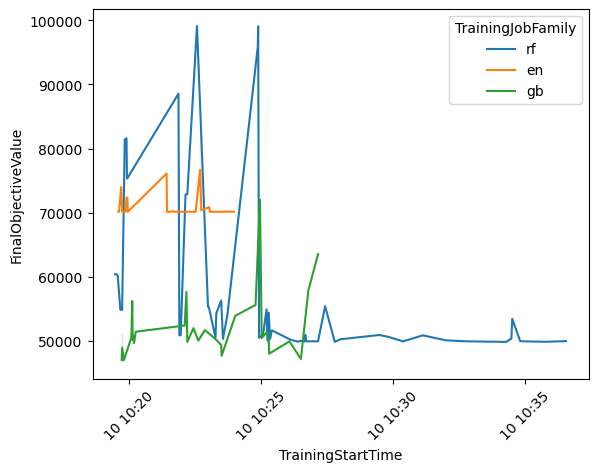

In [18]:
ax = sns.lineplot(data=df_tuner_results, x="TrainingStartTime", y="FinalObjectiveValue", hue="TrainingJobFamily")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

#### Final Objective Value Change per JobDefinitionName

/tmp/ipykernel_10548/2631572192.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


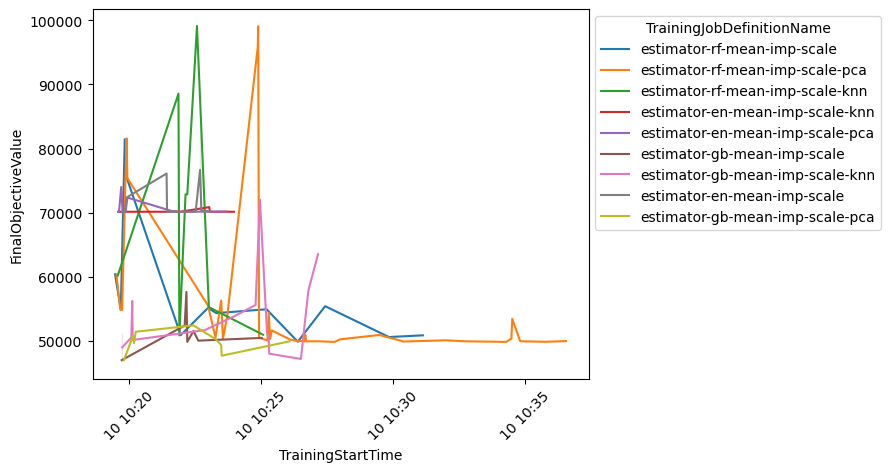

In [19]:
ax = sns.lineplot(data=df_tuner_results, x="TrainingStartTime", y="FinalObjectiveValue", hue="TrainingJobDefinitionName")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

<AxesSubplot: xlabel='l1_ratio', ylabel='alpha'>

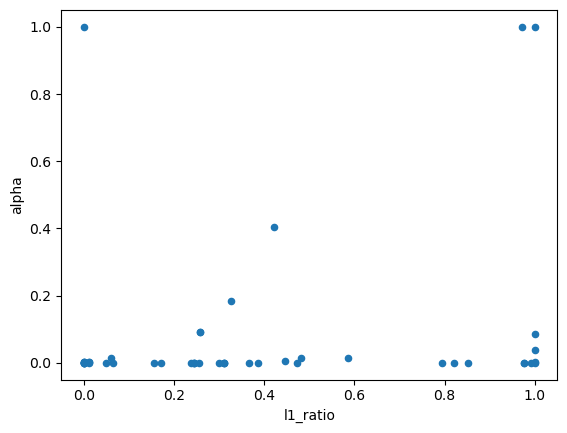

In [20]:
df_tuner_results.loc[df_tuner_results["TrainingJobFamily"] == "en", ["l1_ratio", "alpha"]].plot.scatter("l1_ratio", "alpha")

## Select Best Model

In [21]:
df_best_job = df_tuner_results.loc[df_tuner_results["FinalObjectiveValue"] == df_tuner_results["FinalObjectiveValue"].min()]
df_best_job
BEST_MODEL_FAMILY = df_best_job["TrainingJobFamily"].values[0]

In [22]:
tuners.get(BEST_MODEL_FAMILY).best_training_job()

'custom-automl-gb-231110-1018-001-a47fc731'

In [23]:
tuners.get(BEST_MODEL_FAMILY).best_estimator()


2023-11-10 10:22:24 Starting - Preparing the instances for training
2023-11-10 10:22:24 Downloading - Downloading input data
2023-11-10 10:22:24 Training - Training image download completed. Training in progress.
2023-11-10 10:22:24 Uploading - Uploading generated training model
2023-11-10 10:22:24 Completed - Resource reused by training job: custom-automl-gb-231110-1018-016-5c954346


## Deploy Best Model

In [24]:
predictor = tuners.get(BEST_MODEL_FAMILY).deploy(
    initial_instance_count=1,
    instance_type="ml.c4.large",
    endpoint_name=f"custom-automl-endpoint-{BEST_MODEL_FAMILY}",
)


2023-11-10 10:22:24 Starting - Preparing the instances for training
2023-11-10 10:22:24 Downloading - Downloading input data
2023-11-10 10:22:24 Training - Training image download completed. Training in progress.
2023-11-10 10:22:24 Uploading - Uploading generated training model
2023-11-10 10:22:24 Completed - Resource reused by training job: custom-automl-gb-231110-1018-016-5c954346
------!

## Cleanup
Delete the model endpoint if you deployed it. Endpoints should be deleted when no longer in use, since (per [SageMaker pricing page](https://aws.amazon.com/sagemaker/pricing/)) they’re billed by time deployed.

In [25]:
# NOTE: Don't forget to delete the endpoint afterwards
sm_client.delete_endpoint(EndpointName=predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'ResponseMetadata': {'RequestId': 'bbd6995c-4ac9-4d4e-9f6d-fd4a0303c617',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bbd6995c-4ac9-4d4e-9f6d-fd4a0303c617',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 10 Nov 2023 12:52:54 GMT'},
  'RetryAttempts': 0}}